# Introduction
The Federal National Mortgage Association (FNMA), also known as Fannie Mae, is a government sponsored corporation founded in 1938 whose primary purpose, according to [this source](https://en.wikipedia.org/wiki/Fannie_Mae), is "to expand the secondary mortgage market by securitizing mortgages in the form of mortgage-backed securities, allowing lenders to reinvest their assets into more lending and in effect increasing the number of lenders in the mortgage market by reducing the reliance on locally based savings and loan associations." In short, Fannie Mae purchases mortgage loans from primary lenders like Bank of America and Wells Fargo, among several others. After these mortgages are acquired, Fannie Mae sells them as securities in the bond market. According to [this source](http://home.howstuffworks.com/real-estate/buying-home/mortgage16.htm), these sales "provide lenders with the liquidity to fund more mortgages, and until 2006, the mortgage-backed securities (MBS) sold by [Fannie Mae] were considered solid investments." Unfortunately, however, not all borrowers whose loans have been purchased by Fannie Mae are able to repay their mortgages in a timely manner, and many end up defaulting at some point. In fact, between 2006 and 2008, many hundreds of thousands of people had defaulted, causing these securities to decreases significantly in value, thereby strongly impacting the global economy.

On its website, Fannie Mae has made a subset of its Single Family Loan Performance (SFLP) data available to anyone interested in looking at it. The SFLP data cover the years 2000-2015, and can be downloaded [here](http://www.fanniemae.com/portal/funding-the-market/data/loan-performance-data.html). The goal of this project it so see if we can predict from this data, with some accuracy, those borrowers who are most at risk of defaulting on their mortgage loans. Let's get started!

# Loading and Cleaning the Data

Once downloaded, one will find that the SFLP data is divided into two files called Acquisition\*.txt and Performance\*.txt, where the \* is a placeholder for the particular year and quarter of interest. For the purposes of this project, we're using the quarter 4 data of 2007 which contains a reasonable number of defaults to analyze. The aquisition data contains personal information for each of the borrowers, including an individual's debt-to-income ratio, credit score, and loan amount, among several other things. The perfomance data contains information regarding loan payment history, and whether or not a borrower ended up defaulting on their loan. Additional information regarding the contents of these two files can be found in the [Layout](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_File_layout.pdf) and [Glossary of Terms](https://loanperformancedata.fanniemae.com/lppub-docs/FNMA_SF_Loan_Performance_Glossary.pdf) files.

Let’s begin by importing the appropriate Python libraries and reading in the data.

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as mp
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

acquisition = ['LoanID','Channel','SellerName','OrigInterestRate','OrigUnpPrinc','OrigLoanTerm',
               'OrigDate','FirstPayment','OrigLTV','OrigCLTV','NumBorrow','DTIRat','CreditScore',
               'FTHomeBuyer','LoanPurpose','PropertyType','NumUnits','OccStatus','PropertyState',
               'Zip','MortInsPerc','ProductType','CoCreditScore','MortInsType','RelMortInd'];

performance = ['LoanID','MonthRep','Servicer','CurrInterestRate','CurActUnpBal','LoanAge',
               'MonthsToMaturity','AdMonthsToMaturity','MaturityDate','MSA','CLDS','ModFlag',
               'ZeroBalCode','ZeroBalDate','LastInstallDate','ForeclosureDate','DispositionDate',
               'PPRC','AssetRecCost','MHRC','ATFHP','NetSaleProceeds','CreditEnhProceeds','RPMWP',
               'OFP','NIBUPB','PFUPB','RMWPF','FPWA','ServicingIndicator'];

df_acq = pd.read_csv('/Users/degrave/Downloads/2007Q4/Acquisition_2007Q4.txt', sep='|', names=acquisition, index_col=False)
df_per = pd.read_csv('/Users/degrave/Downloads/2007Q4/Performance_2007Q4.txt', sep='|', names=performance, index_col=False)

Let's take a look at the head of the two dataframes.

In [174]:
df_acq.head()

,LoanID,Channel,SellerName,OrigInterestRate,OrigUnpPrinc,OrigLoanTerm,OrigDate,FirstPayment,OrigLTV,OrigCLTV,...,PropertyType,NumUnits,OccStatus,PropertyState,Zip,MortInsPerc,ProductType,CoCreditScore,MortInsType,RelMortInd
0,100002296854,C,"BANK OF AMERICA, N.A.",6.625,343000,360,10/2007,12/2007,86,86.0,...,PU,1,P,CO,809,25.0,FRM,756.0,2.0,N
1,100006876815,C,"BANK OF AMERICA, N.A.",6.250,400000,360,10/2007,12/2007,62,62.0,...,SF,1,P,CA,920,NaN,FRM,790.0,NaN,N
2,100008184591,B,OTHER,6.625,81000,360,11/2007,01/2008,64,82.0,...,SF,1,P,LA,708,NaN,FRM,NaN,NaN,N
3,100008870761,B,AMTRUST BANK,6.500,119000,360,11/2007,01/2008,71,71.0,...,CO,1,P,IL,600,NaN,FRM,NaN,NaN,N
4,100013284158,B,"BANK OF AMERICA, N.A.",6.625,205000,360,10/2007,12/2007,27,27.0,...,SF,1,P,CA,907,NaN,FRM,NaN,NaN,N


In [175]:
df_per.head()

,LoanID,MonthRep,Servicer,CurrInterestRate,CurActUnpBal,LoanAge,MonthsToMaturity,AdMonthsToMaturity,MaturityDate,MSA,...,ATFHP,NetSaleProceeds,CreditEnhProceeds,RPMWP,OFP,NIBUPB,PFUPB,RMWPF,FPWA,ServicingIndicator
0,100002296854,11/01/2007,"BANK OF AMERICA, N.A.",6.625,NaN,0,360,359.0,11/2037,17820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002296854,12/01/2007,NaN,6.625,NaN,1,359,358.0,11/2037,17820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100002296854,01/01/2008,NaN,6.625,NaN,2,358,357.0,11/2037,17820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100002296854,02/01/2008,NaN,6.625,NaN,3,357,356.0,11/2037,17820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100002296854,03/01/2008,NaN,6.625,NaN,4,356,355.0,11/2037,17820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In the performance data, we are really only interested in a few columns. These include the *LoanID* and *ForeclosureDate* columns, as this will give us the borrower identifiaction number and whether or not they ended up defaulting on their loan. We are also interested in the current loan interest rate, current unpaid balance of the loan, the loan age, and the number of month to maturity for the loan.

In [176]:
df_per = df_per[['LoanID','Servicer','CurrInterestRate','CurActUnpBal','LoanAge',
                 'MonthsToMaturity','ForeclosureDate']].reset_index(drop=True)

df_per.drop_duplicates(subset=['LoanID'], keep='last', inplace=True)

df_per.head()

,LoanID,Servicer,CurrInterestRate,CurActUnpBal,LoanAge,MonthsToMaturity,ForeclosureDate
14,100002296854,NaN,6.625,338280.97,14,346,NaN
83,100006876815,NaN,6.250,369125.79,69,291,NaN
204,100008184591,NaN,5.000,62430.58,120,240,NaN
300,100008870761,NaN,6.500,103772.66,96,264,NaN
422,100013284158,NaN,4.250,198813.09,121,432,NaN


After reading in the two datasets, we can join the acquisition and performance dataframes using the *LoanID* column. We can then remove *LoanID*, as it will not be useful in predicting defaults later on. The resulting dataframe contains the ForeclosureDate column, as will be our target variable. For clarity, we will also rename this column *Default*.

In [177]:
df = pd.merge(df_acq, df_per, on='LoanID')

df.drop('LoanID', axis=1, inplace=True)

df.rename(index=str, columns={"ForeclosureDate": 'Default'}, inplace=True)

In the *Default* column, a 1 is placed next to any borrower that was found to have defaulted, and a 0 is placed next to any borrower that has not defaulted.

In [178]:
df['Default'].fillna(0, inplace=True)

df.loc[df['Default'] != 0, 'Default'] = 1

df['Default'] = df['Default'].astype(int)

The final dataframe has 379,074 rows and 25 columns, and contains information regarding loan interest rate, payment dates, property state, and the last few digits of each property ZIP Code, among several other things. Many of the columns contain missing values, and these will have to be dealt with before we start making our predictions. Let's see how many null values are in each column.

In [179]:
df_null = pd.DataFrame({'Count': df.isnull().sum(), 'Percent': 100*df.isnull().sum()/len(df)})
df_null[df_null['Count'] > 0]

,Count,Percent
OrigInterestRate,1,0.000256
OrigCLTV,32,0.008180
NumBorrow,6,0.001534
DTIRat,11481,2.934748
CreditScore,626,0.160017
MortInsPerc,306284,78.291655
CoCreditScore,234970,60.062524
MortInsType,306284,78.291655
Servicer,387590,99.074919
CurActUnpBal,10,0.002556


The table above shows the number of null values in each column, along with the percentage of the column made up of these nulls. For example, the *DTIRat* column contains 11,481 null values, and these null values make up 2.9% of the entire column. We can see the dataset has ten columns with at least one null value, and in several cases (*MortInsPerc*, *CoCreditScore*, *MortInsType*, and *Servicer*) the percentage of nulls is extremely large.

Normally, if the percentage of nulls was small (say less than 10% or so), I would try to fill them in using the column mean, median, or mode, or I would try to predict their values using a machine learning algorithm. However, since the our dataset is so large, we can drop the null rows entirely without much consequence.

In [180]:
df.drop(['MortInsPerc','CoCreditScore','MortInsType','Servicer'], axis=1, inplace=True)

df.dropna(inplace=True)

There is also only a single variable in the *ProductType* column, so this feature won't have any predictive power. We'll drop this column as well.

In [181]:
df.drop('ProductType', axis=1, inplace=True)

# Data Exploration

Before we move on, we should perform an exploration of features we'll find to be important later on to see what they contain. Let's look at the distribution of the *Default* column.

(0, 1)

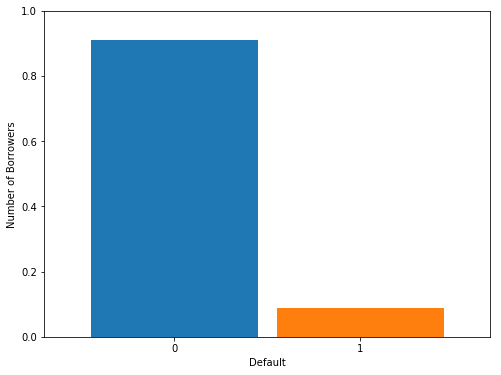

In [56]:
fig, axes = mp.subplots(nrows=1, ncols=1, figsize=(8,6))

ax = df['Default'].value_counts().divide(len(df)).plot.bar(width=0.9, rot=0)
ax.set_xlabel('Default')
ax.set_ylabel('Number of Borrowers')
ax.set_ylim(0,1)

The two classes (default = 1, non-default = 0) are extremely imbalanced here; defaulters make up only about 10% of all borrowers in this particular dataset. For very imbalanced datasets, it is often the case that machine learning algorithms will have a tendency to always predict the more dominant class when presented with new, unseen test data. To avoid an overabundance of false negatives, we can eventually balance the classes so that the dataframe contains equal numbers of defaulters and non-defaulters. However, let’s continue looking at some more of the data first.

Text(0.5,0.98,'')

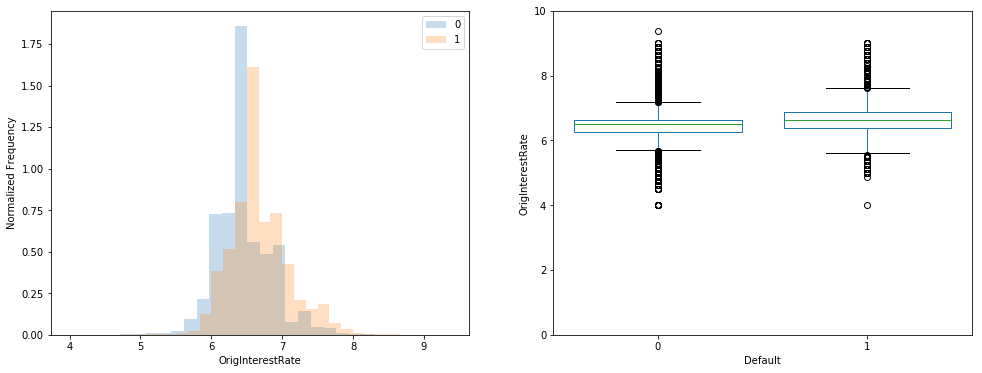

In [57]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

ax = df.groupby('Default')['OrigInterestRate'].plot.hist(bins=30, density=True, alpha=0.25, ax=axes[0])
ax[0].set_ylabel('Normalized Frequency')
ax[0].set_xlabel('OrigInterestRate')
ax[0].legend()

ax = df.boxplot(by='Default', column='OrigInterestRate', grid=False, widths=(0.8, 0.8), ax=axes[1])
ax.set_ylabel('OrigInterestRate')
ax.set_ylim(0,10)
ax.set_title('')
fig.suptitle('')

The right-hand figure above shows original interest rate boxplots for both the default and non-default classes. Boxplots are assembled such that 25% of the data values are contained between the lowest whisker and the bottom of the box, 50% of the values are contained within the box itself, and 25% of the values are spanned between the top of the box and the top whisker. The median value of the data is represented by the horizontal line in the middle of each box.

It looks like the original loan interest rates for this time period sat around 6.5%. The distributions for the two classes is similar, though interest rates for the default class were slightly higher.

(0, 1)

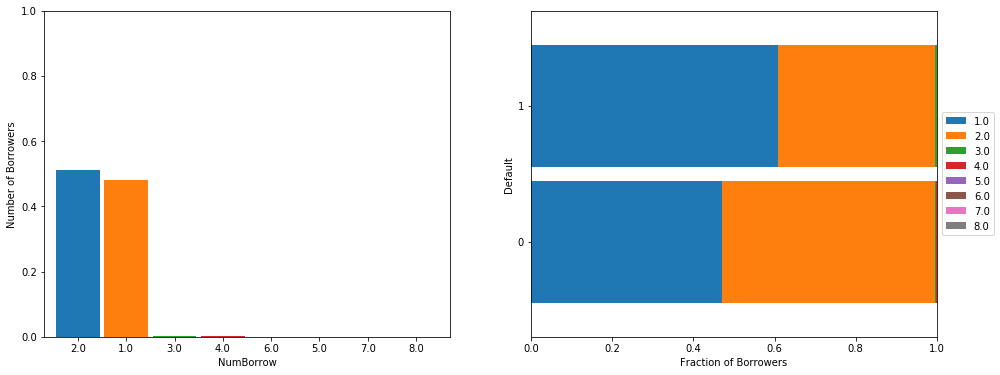

In [58]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

ax = df['NumBorrow'].value_counts().divide(len(df)).plot.bar(width=0.9, ax=axes[0], rot=0)
ax.set_xlabel('NumBorrow')
ax.set_ylabel('Number of Borrowers')
ax.set_ylim(0,1)

xtab = pd.pivot_table(df, index='Default', columns='NumBorrow', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
ax = xtab.plot.barh(stacked=True, width=0.9, ax=axes[1])

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('Fraction of Borrowers')
ax.set_ylabel('Default')
ax.set_xlim(0,1)

The vast majority of all loans (nearly 100%) were for one or two individuals. Presumably the 2-borrower loans were usually for couples. Interestingly, more defaults occurred when only a single borrower was involved, perhaps because 2-borrower households had higher joint incomes and could more easily pay off the loan. What do the debt-to-income ratios look like for the two classes?

Text(0.5,0.98,'')

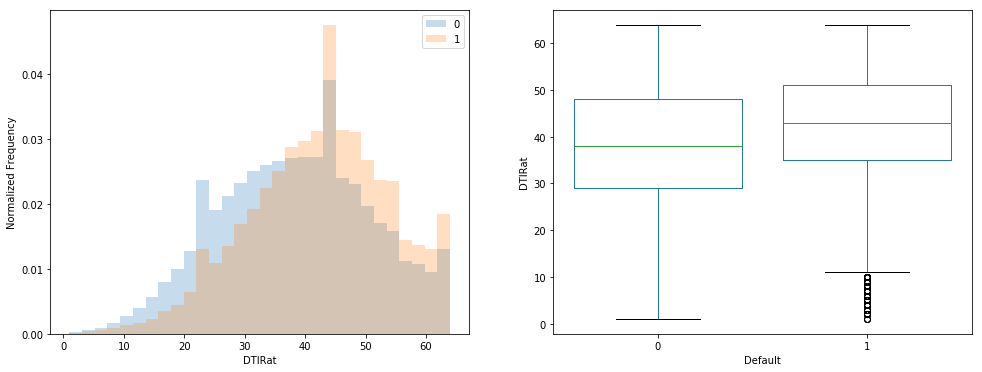

In [59]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

ax = df.groupby('Default')['DTIRat'].plot.hist(bins=30, density=True, alpha=0.25, ax=axes[0])
ax[0].set_ylabel('Normalized Frequency')
ax[0].set_xlabel('DTIRat')
ax[0].legend()

ax = df.boxplot(by='Default', column='DTIRat', grid=False, widths=(0.8, 0.8), ax=axes[1])
ax.set_ylabel('DTIRat')
ax.set_title('')
fig.suptitle('')

As we might have guessed, defaulters typicaly had higher debt-to-income ratios than non-defaulters. Another strong predictor of default is likely to be the borrower's credit score. Let's check out the distributions for this feature.

Text(0.5,0.98,'')

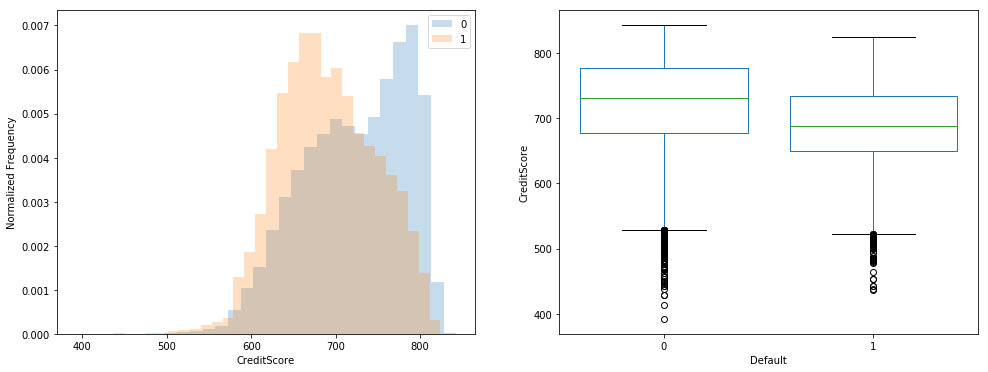

In [60]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

ax = df.groupby('Default')['CreditScore'].plot.hist(bins=30, density=True, alpha=0.25, ax=axes[0])
ax[0].set_ylabel('Normalized Frequency')
ax[0].set_xlabel('CreditScore')
ax[0].legend()

ax = df.boxplot(by='Default', column='CreditScore', grid=False, widths=(0.8, 0.8), ax=axes[1])
ax.set_ylabel('CreditScore')
ax.set_title('')
fig.suptitle('')

There are fairly large differences here between the two classes. On average, defaulters had credit scores below 700, while non-defaulters were generally above 700.

Lastly, in looking at the various data features, the borrower’s location (ZIP Code) also seems to be a possible indicator of whether or not a default will occur. The figure below shows the fraction of people that have defaulted from the ten most common ZIP Codes. Comparing certain locations (for example, ZIP Code 853 vs. 750), there are significant differences in the fraction of borrowers that defaulted.

(0, 1)

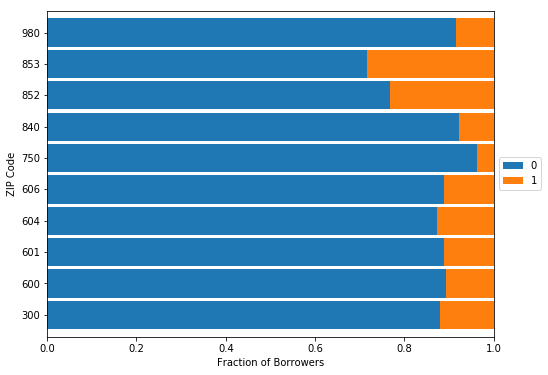

In [69]:
data = df[df['Zip'].isin(df['Zip'].value_counts().index.tolist()[:10])]

xtab = pd.pivot_table(data, index='Zip', columns='Default', aggfunc='size')
xtab = xtab.div(xtab.sum(axis=1), axis=0)
ax = xtab.plot.barh(stacked=True, width=0.9, figsize=(8,6))

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel('Fraction of Borrowers')
ax.set_ylabel('ZIP Code')
ax.set_xlim(0,1)

Before going any further, we should check to see if any of the features in our dataset are highly correlated. Highly correlated features can often lead to unstable models with poor interpretability.

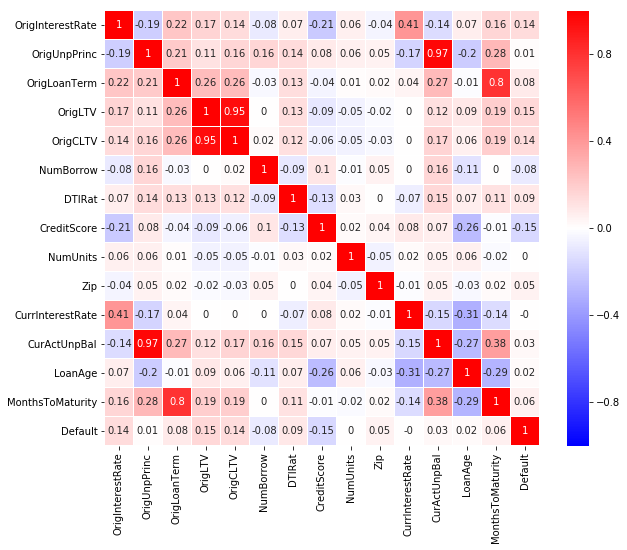

In [182]:
fig, axes = mp.subplots(figsize=(10,8))

sns.heatmap(np.round(df.corr(), 2), annot=True, cmap='bwr',
                vmin=-1, vmax=1, square=True, linewidths=0.5)

We can see that the correlation between *CurActUnpBal* and *OrigUnpPrinc* is very high, and so is the correlation between *OrigCLTV* and *OrigLTV*. Let's plot these features against one another and see what we find.

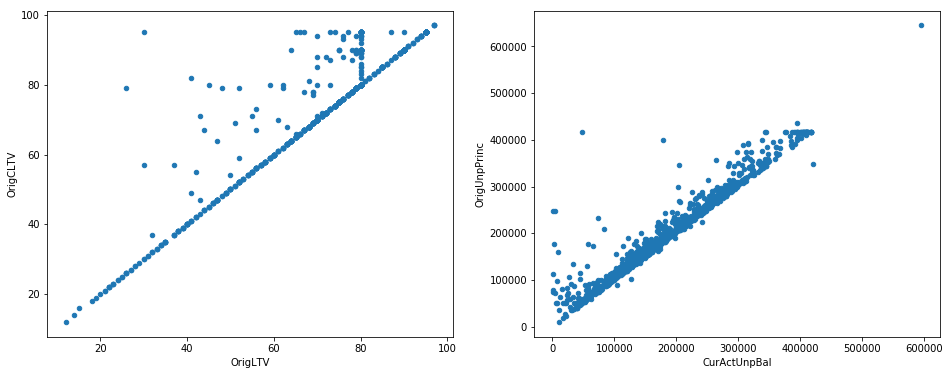

In [183]:
fig, axes = mp.subplots(nrows=1, ncols=2, figsize=(16,6))

df.dropna().sample(n=1000).plot.scatter(x='OrigLTV', y='OrigCLTV', ax=axes[0])
df.dropna().sample(n=1000).plot.scatter(x='CurActUnpBal', y='OrigUnpPrinc', ax=axes[1])

It looks like for any value of *OrigLTV* or *CurActUnpBal*, *OrigCLTV* and *OrigUnpPrinc* show more variability. Let's drop these two features from the dataset.

In [184]:
df.drop(['OrigCLTV','OrigUnpPrinc'], axis=1, inplace=True)

df.reset_index(drop=True, inplace=True)

Lastly, we may be able to get some useful predictive information from the original loan and first loan payment dates. We'll grab the month and year from both of these.

In [187]:
df['OrigDateMonth'] = df['OrigDate'].apply(lambda x: x.split('/')[0].strip()).astype(object)
df['OrigDateYear'] = df['OrigDate'].apply(lambda x: x.split('/')[1].strip()).astype(object)

df['FirstMonth'] = df['FirstPayment'].apply(lambda x: x.split('/')[0].strip()).astype(object)
df['FirstYear'] = df['FirstPayment'].apply(lambda x: x.split('/')[1].strip()).astype(object)

df.drop(['OrigDate','FirstPayment'], axis=1, inplace=True)

# Transform Data

Before building the predictive model, we can transform the data a little bit to get it into a format that will help us to maximize our model's predictive capabilities. Some models perform more poorly when feature variable distributions are very highly skewed. There are a few options to remedy this - we could take the log or square root of these features, which sometimes helps to get them into a more normal, Gaussian shape. We could also apply something called the Box-Cox transformation, which is actually a whole family of transformations that encompasses the square root, cube root, and essentially any other power law. We'll apply the Box-Cox transformation to our numerical (float) features below.

In [188]:
numerical = df.columns[df.dtypes == 'float']

for i in numerical:
    if df[i].min() > 0:
        transformed, lamb = boxcox(df.loc[df[i].notnull(), i])
        if np.abs(lamb) > 1.02:
            df.loc[df[i].notnull(), i] = transformed

The ZIP Code feature is actually categorical, so we'll declare this to be of type *object*.

In [189]:
df['Zip'] = df['Zip'].astype('object')

We can now one-hot-encode the categorical dummy variables.

In [190]:
df = pd.get_dummies(df, drop_first=True)

Lastly, let's randomly sample a subset of the data to use for testing.

In [192]:
testdata = df.sample(n=5000, random_state=0)

# Model Selection

Alright, now we're ready to build some models! We'll try two approaches here:

1. Balance the dataset so that there are just as many non-defaulters as there are defaulters.
2. Balance the dataset, but upsample the default class while downsampling the non-default class.

### Try a Balanced Dataset

Let's first try a balanced dataset without any resampling.

In [202]:
from sklearn.model_selection import cross_val_score

data = df[~df.index.isin(testdata.index)].reset_index(drop=True)

y_default = data[data['Default'] == 1]
n_default = data[data['Default'] == 0].sample(n=len(y_default), random_state=0)

data = y_default.append(n_default)

X = data.drop('Default', axis=1)
y = data['Default']

Once we have our new, balanced dataset we can scale the data so that each column has a mean of zero and unit standard deviation.

In [203]:
sc = StandardScaler()

numerical = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')].tolist()

X[numerical] = sc.fit_transform(X[numerical])

To compare models we'll examine both the overall prediction accuracy as well as the receiver operating characteristic (ROC) curves. The function below builds these ROC curves for the models.

In [204]:
def createROC(models, X, y, Xte, yte):
    false_p, true_p = [], []

    for i in models.keys():
        models[i].fit(X, y)

        fp, tp, thresh = roc_curve(yte, models[i].predict_proba(Xte)[:,1])

        true_p.append(tp)
        false_p.append(fp)
    return true_p, false_p

We'll try a variety of models to see which performs the best during cross-validation, and on the test set. Below, we loop over four models:

1. A linear discriminant analysis model
2. A multinomial naive Bayes model
3. A random forest model
4. A logistic regression model

In [88]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = {'LDA': LinearDiscriminantAnalysis(),
          'MNB': MultinomialNB(),
          'RF': RandomForestClassifier(n_estimators=100),
          'LR': LogisticRegression(C=1)}

smallset = {}
for i in models.keys():
    scores = cross_val_score(models[i], X - np.min(X) + 1, y, cv=3)
    smallset[i] = scores
    print(i, scores, np.mean(scores))

LDA [0.73850054 0.73827418 0.74037852] 0.7390510798780734
MNB [0.69653205 0.6945853  0.69578013] 0.6956324936657072
RF [0.79147048 0.79703912 0.79747351] 0.7953277035347286
LR [0.74090004 0.74339008 0.74196323] 0.7420844489688104


The printed values above give the three-fold cross-validation accuracy scores along with their average for each of the models. We can see that linear discriminant analysis and logistic regression give very similary results, while the random forest performs the best, and multinomial naive Bayes performs the worst.

Let's get our test dataset scaled.

In [157]:
Xte = testdata.drop('Default', axis=1)
yte = testdata['Default']

numerical = Xte.columns[(Xte.dtypes == 'float64') | (Xte.dtypes == 'int64')].tolist()

Xte[numerical] = sc.fit_transform(Xte[numerical])

We can now build the ROC curves.

In [90]:
true_p_smallset, false_p_smallset = createROC(models, X - np.min(X) + 1, y, Xte - np.min(Xte) + 1, yte)

Finally, we can fit our best random forest model and make some plots of performance.

In [91]:
model = RandomForestClassifier(n_estimators=100)

model.fit(X, y)

predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

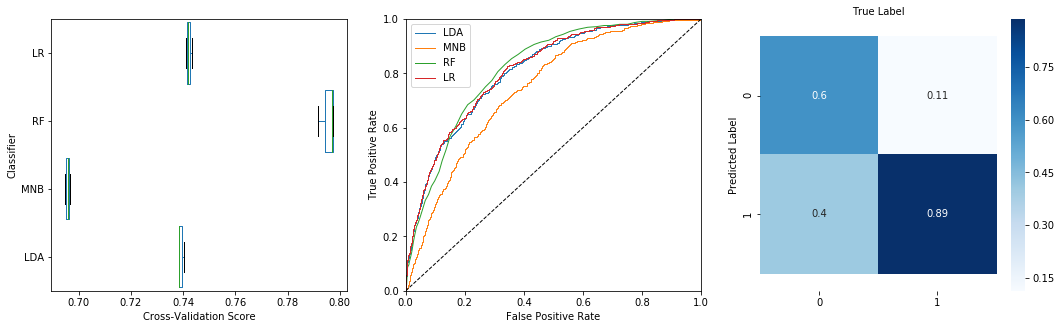

In [103]:
fig, axes = mp.subplots(nrows=1, ncols=3, figsize=(18,5))

ax = pd.DataFrame(smallset).boxplot(widths=(0.9,0.9,0.9,0.9), grid=False, vert=False, ax=axes[0])
ax.set_ylabel('Classifier')
ax.set_xlabel('Cross-Validation Score')

for i in range(0, len(true_p_smallset)):
    axes[1].plot(false_p_smallset[i], true_p_smallset[i], lw=1)

axes[1].plot([0, 1], [0, 1], '--k', lw=1)
axes[1].legend(models.keys())
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_xlim(0,1)
axes[1].set_ylim(0,1)

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues', ax=axes[2]);
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')
ax.axis('equal')

The left-hand figure above compares the cross-validation accuracy scores of the four models tested. We can see that the random forest model was far and away the best performer at nearly 80% accuracy. The middle figure shows the corresponding ROC curve for each model. Ideally, the ROC curve for a perfect model would hug the upper left-hand corner of the box, indicating a high false positive rate and low false negative rate. We see that the random forest curve most closely fits this description, and all models tested are significantly better than random chance (the diagonal black line).

The right-hand figure shows the confusion matrix for the random forest model applied to the test dataset. The confusion matrix is a table which shows the percentage of correct (true positives or true negatives) and incorrect (false positive or false negative) predictions. In the table, the true class is given along the x-axis, while the predicted class is given along the y-axis. The confusion matrix shows that for all non-defaulters in our dataset, the algorithm correctly classifies them as non-defaulters 60% of the time (true negatives), and incorrectly classifies them as defaulters 40% of the time (false positives). For all of the defaulters in our dataset, we correctly classify them as such 89% of the time (true positives), and incorrectly classify them 11% of the time (false negatives). In terms of profitability to Fannie Mae, false negatives are the most important metric here. This is because Fannie Mae loses money when we incorrectly label a defaulter as being a non-defaulter. The fact that we incorrectly classify some of our non-defaulters is of little consequence because there are so many of them present in the full data set (i.e., we can more easily find non-defaulters to purchase loans).

Lastly, let's tune the random forest model to find the *n_estimators* parameter that maximizes classification accuracy.

# Tuning the Model

We'll use Scikit-Learn's *GridSearchCV* to loop over four different values of the *n_estimators* parameter, performing 5-fold cross-validation each time. We'll print the best *n_estimators* value found along with the corresponding cross-validation accuracy, and then use this model in a final prediction.

In [230]:
params = {'n_estimators': [50, 100, 200, 400, 600, 800]}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params,
                                   scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X, y)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'n_estimators': 800}
0.7982168137594506


It looks like the best model was the one with 800 trees. Let's see how the cross-validation score improved with *n_estimators*.

Text(0,0.5,'5-Fold Cross-Validation Score')

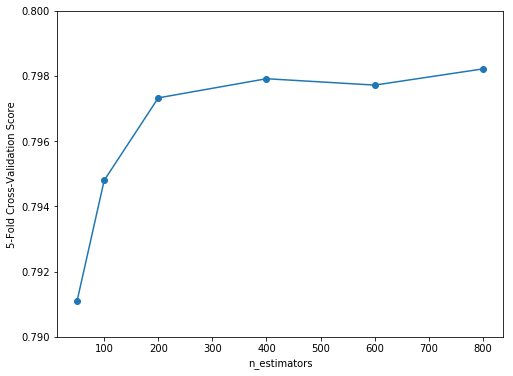

In [278]:
r = pd.DataFrame()
r['x'] = [i for i in params.values()][0]
r['y'] = [i[1] for i in grid_search.grid_scores_]

ax = r.plot(x='x', y='y', legend=False, linestyle='-', marker='o', figsize=(8,6))
ax.set_ylim(0.79,0.8)
ax.set_xlabel('n_estimators')
ax.set_ylabel('5-Fold Cross-Validation Score')

The cross-validation accuracy jumped up very quickly when 200 estimators were included in the model, and leveled off here for all subsequent values. Despite the fact that 800 estimators gave the best score, we can achieve a score within 1% of this value using a much smaller number of trees.

Let's build the final model and test it out.

In [266]:
grid_search.best_estimator_.fit(X, y)

predict = model.predict(Xte)

(0.0, 2.0, 2.0, 0.0)

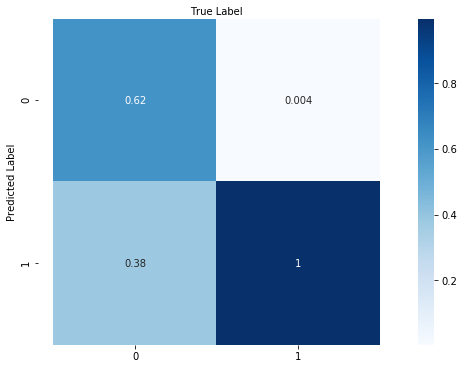

In [269]:
fig, axes = mp.subplots(figsize=(8,6))

cm = confusion_matrix(yte, predict).T
cm = cm.astype('float')/cm.sum(axis=0)

ax = sns.heatmap(cm, annot=True, cmap='Blues');
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.xaxis.set_label_position('top')
ax.axis('equal')

The new model is able to correctly predict 100% of the defaulters in the test dataset, while keeping the non-default accuracy roughly the same.

The random forest model is nice in that it allows one to easily print a list of features that were most important when separating the two classes.

Text(0,0.5,'Relative Importance')

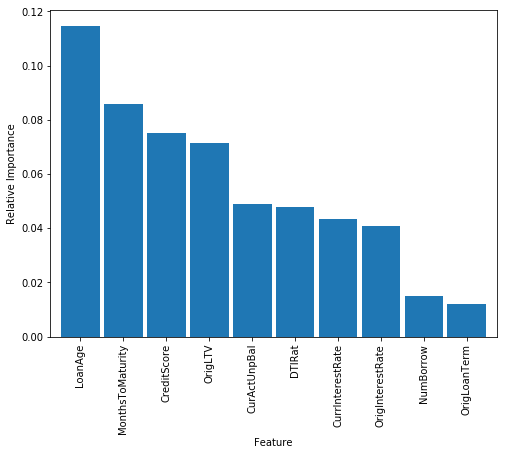

In [270]:
r = pd.DataFrame(columns=['Feature','Importance'])

ncomp = 10

r['Feature'] = feat_labels = X.columns
r['Importance'] = model.feature_importances_
r.set_index(r['Feature'], inplace=True)

ax = r.sort_values('Importance', ascending=False)[:ncomp].plot.bar(width=0.9, legend=False, figsize=(8,6))
ax.set_ylabel('Relative Importance')

It looks like loan age, the number of months to maturity, credit score, debt-to-income ratio, and interest rates are among the most informative features. Examining feature importance in this way could be useful in reducing the dimensionality of the dataset if it were deemed to large to process in a reasonable amount of time.

# Concluding Remarks

In this project, we’ve detailed how to predict loan defaults in the Fannie Mae Single Family Loan Performance data. The random forest classifier gave us a nice baseline algorithm by which we could identify loan defaulters with reasonably good accuracy, precision, and recall.

A number of tests could be conducted to try and further improve the analysis. For example, one could find the optimal number of estimators (trees) to use in the model. A value of 100 was shown to perform quite well, but could be tuned to give even better performance. We could try some more clever feature engineering. For example, the months to maturity and loan age features could be combine to produce a "percent paid off" feature, or something similar.

Well, that’s all I have for now. Thanks for following along!

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>